#### Базовые настройки для внедрения изображений и оформления внешнего вида графиков

In [199]:
from IPython.display import Image
%matplotlib inline

import matplotlib.pyplot as plt

DPI = 600   # разрешающая способность файла png: дисплей=300, публикация=600

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Ubuntu Condensed']

#### Настройки с учетом версий библиотеки scikit-learn

In [200]:
# альтернативный синтаксис для sklearn 0.18
from distutils.version import LooseVersion as Version
from sklearn import __version__ as sklearn_version
if Version(sklearn_version) < '0.18':
    from sklearn.grid_search import train_test_split
else:
    from sklearn.model_selection import train_test_split

#### Импорт набора данных

In [201]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import Imputer

url = 'Wholesale customers data.csv'
df = pd.read_csv(url)
df

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185
...,...,...,...,...,...,...,...,...
435,1,3,29703,12051,16027,13135,182,2204
436,1,3,39228,1431,764,4510,93,2346
437,2,3,14531,15488,30243,437,14841,1867
438,1,3,10290,1981,2232,1038,168,2125


#### Устранение строк с пропущенными значениями

In [202]:
df.isnull().sum()

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

#### Стандартизация признаков

In [203]:
from sklearn.preprocessing import StandardScaler

X = df.iloc[:, 3:5].values
scaler = StandardScaler()
scaler.fit(X)
X_std = scaler.transform(X)

### Группирование объектов по подобию методом k средних

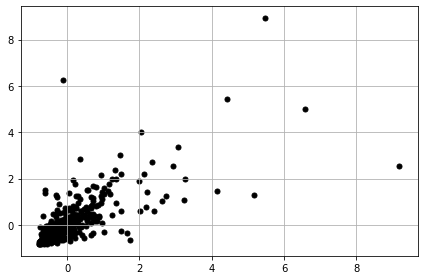

In [204]:
plt.scatter(X_std[:,0], X_std[:,1], c='black', marker='o', s=25)
plt.grid()
plt.tight_layout()
plt.show()

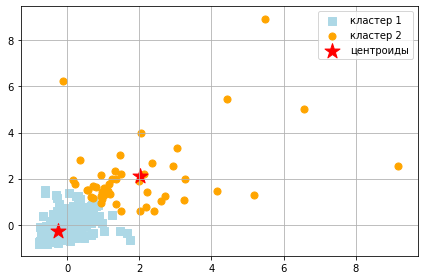

In [205]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=2, 
            init='random', 
            n_init=10, 
            max_iter=300,
            tol=1e-04,
            random_state=0)
y_km = km.fit_predict(X_std)

plt.scatter(X_std[y_km==0,0], 
            X_std[y_km==0,1], 
            s=50, 
            c='lightblue', 
            marker='s', 
            label='кластер 1')
plt.scatter(X_std[y_km==1,0], 
            X_std[y_km==1,1], 
            s=50, 
            c='orange', 
            marker='o', 
            label='кластер 2')
plt.scatter(km.cluster_centers_[:,0], 
            km.cluster_centers_[:,1], 
            s=250, 
            marker='*', 
            c='red', 
            label='центроиды')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

#### Использование метода локтя для нахождения оптимального числа кластеров

In [206]:
print('Искажение: %.2f' % km.inertia_)

Искажение: 432.39


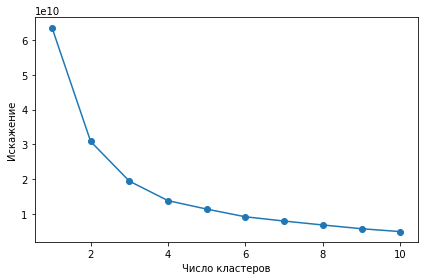

In [207]:
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, 
                init='k-means++', 
                n_init=10, 
                max_iter=300, 
                random_state=0)
    km.fit(X)
    distortions.append(km.inertia_)
plt.plot(range(1,11), distortions , marker='o')
plt.xlabel('Число кластеров')
plt.ylabel('Искажение')
plt.tight_layout()
plt.show()

#### Cилуэтный график

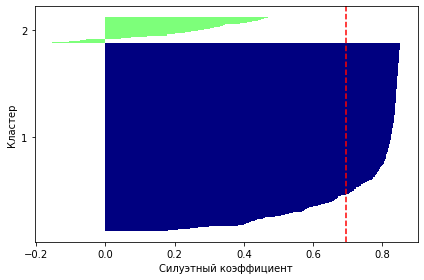

In [208]:
from matplotlib import cm
from sklearn.metrics import silhouette_samples

km = KMeans(n_clusters=2, 
            init='k-means++', 
            n_init=10, 
            max_iter=300,
            tol=1e-04,
            random_state=0)
y_km = km.fit_predict(X)

cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km==c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(i / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
            edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--") 

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Кластер')
plt.xlabel('Силуэтный коэффициент')

plt.tight_layout()
plt.show()

#### Иерархическая кластеризация данных

In [209]:
from scipy.cluster.hierarchy import linkage

row_clusters = linkage(X_std, method='complete', metric='euclidean')
pd.DataFrame(row_clusters, 
             columns=['метка строки 1', 'метка строки 2', 
                      'расстояние', 'число элементов в класт.'],
             index=['кластер %d' %(i+1) for i in range(row_clusters.shape[0])])

,метка строки 1,метка строки 2,расстояние,число элементов в класт.
кластер 1,6.0,297.0,0.001159,2.0
кластер 2,50.0,350.0,0.001871,2.0
кластер 3,121.0,433.0,0.002233,2.0
кластер 4,27.0,236.0,0.002316,2.0
кластер 5,139.0,233.0,0.002924,2.0
...,...,...,...,...
кластер 435,333.0,870.0,4.836391,15.0
кластер 436,871.0,872.0,6.317246,421.0
кластер 437,874.0,875.0,7.252159,436.0
кластер 438,86.0,873.0,7.386481,4.0


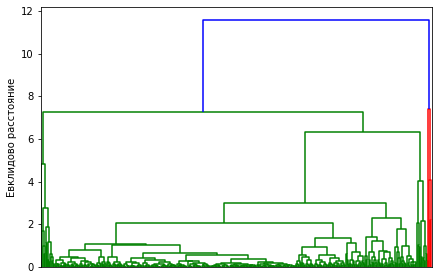

<Figure size 720x720 with 0 Axes>

In [210]:
from scipy.cluster.hierarchy import dendrogram

# сделать дендограмму черной (часть 1/2)
# from scipy.cluster.hierarchy import set_link_color_palette
# set_link_color_palette(['black'])

row_dendr = dendrogram(row_clusters,
                       no_labels=True
                       # сделать дендограмму черной (часть 2/2)
                       # color_threshold=np.inf
                       )
plt.tight_layout()
plt.ylabel('Евклидово расстояние')
plt.figure(figsize=(10, 10))
plt.show()

#### Прикрепление дендограмм к теплокарте

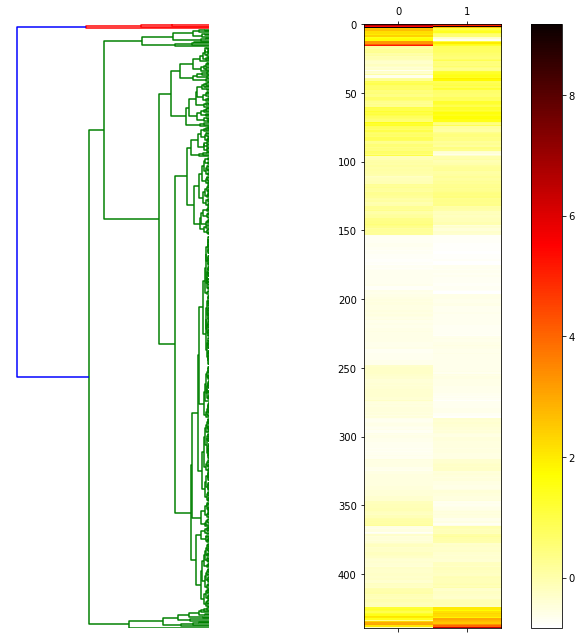

In [211]:
# построить строчную дендограмму
fig = plt.figure(figsize=(14,14), facecolor='white')
axd = fig.add_axes([0.09,0.1,0.2,0.6])

# примечание: для matplotlib >= v1.5.1, использовать orientation='left'
row_dendr = dendrogram(row_clusters, orientation='left', no_labels=True)

# переупорядочить данные относительно кластеризации
#df_rowclust = df.loc[row_dendr['leaves'][::-1]]
df_rowclust = X_std[row_dendr['leaves'][::-1]]

axd.set_xticks([])
axd.set_yticks([])

# убрать из дендограммы оси и линии сетки 
for i in axd.spines.values():
        i.set_visible(False)

# добавить к графику теплокарту
axm = fig.add_axes([0.1,0.1,0.6,0.6]) # x-полож, y-полож, ширина, высота
cax = axm.matshow(df_rowclust, interpolation='nearest', cmap='hot_r', aspect=0.02)
fig.colorbar(cax)
#axm.set_xticklabels([''] + list(df_rowclust.columns))
#axm.set_yticklabels([''] + list(df_rowclust.index))

plt.show()

#### Локализация областей высокой плотности алгоритмом DBSCAN

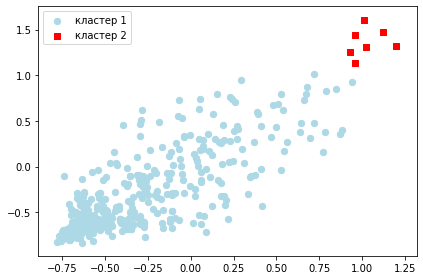

In [212]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.2, min_samples=5, metric='euclidean')
y_db = db.fit_predict(X_std)
plt.scatter(X_std[y_db==0,0], X_std[y_db==0,1], c='lightblue', marker='o', s=40, label='кластер 1')
plt.scatter(X_std[y_db==1,0], X_std[y_db==1,1], c='red', marker='s', s=40, label='кластер 2')
plt.legend()
plt.tight_layout()
plt.show()